### Created simple parameter : 0.4*OXY + 0.3*SECCHI + 0.3*CHLORA measuring water quality and tried predicting it on models provided at models.ipynb with some small modifications, using elements from fertilizers and silicate as X
### works ok mostly based on silicates,  but other matters too r2_score better at greater depths

In [23]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from zipfile import ZipFile
from functools import reduce

import seaborn as sns

from sklearn.utils.validation import column_or_1d
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from pandas.plotting import scatter_matrix

In [ ]:
#default paths to files generated with data_splitting
DATA_BASE = '2022.11.07-merged-single-observation/'
PATHS = ['100', '1000', '1500','2000', '2500', 'average', 'deep', 'standard']
DATA_FILE = '/CLEANED_MERGED_DATA.csv'
DATA_PATH = DATA_BASE + PATHS[6] + DATA_FILE

In [2]:
# load data to data frame
zip_file = ZipFile('./2022.11.07-merged-single-observation.zip')
dfs = {text_file.filename: pd.read_csv(zip_file.open(text_file.filename))
       for text_file in zip_file.infolist()
       if text_file.filename.endswith('.csv') and not text_file.filename[37:].startswith('.')}

df_list=[]
for df in dfs.values():
       df['DATE'] = pd.to_datetime(df['DATE'],dayfirst = True)
       df_list.append(df)

df = reduce(lambda left,right: pd.merge(left.drop_duplicates(subset=['DATE','DEPTH']),right.drop_duplicates(subset=['DATE','DEPTH']),on=['DATE','DEPTH'],how='outer'), df_list)
# df.to_csv('xxxxx.csv')

In [ ]:
#DATAPATH is path to your file
df = pd.read_csv(DATA_PATH,index_col=False)

In [10]:
#drop date and normalize rest of columns
# df = df.drop(['DATE'], axis=1)
df.dropna(inplace=True)
cols = list(set(df.columns))
df[cols] -= df[cols].min()
df[cols] /= df[cols].max()

In [11]:
# quality is linear combitnation of few other parameters
# we used elements occuring in fertilizers and SIO2 (silicate) which comes from rivers as X

X_cols = ['TP', 'TN', 'NO3','NO2','PO4', 'NH4', 'SIO2']
df['quality'] = 0.4*df['OXY'] + 0.3*df['SECCHI'] + 0.3*df['CHLORA']
y_col = ['quality']

X = df[X_cols]
y = df[y_col]
y = column_or_1d(y, warn=True)

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

/var/folders/zf/z_5ht60d3n7gfsmz14cjq6fc0000gn/T/ipykernel_22293/2767477533.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [12]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / (y_true  ) ) ) * 100

In [13]:
# linear regression
lg = LinearRegression()
lg.fit(x_train, y_train)
y_pred = lg.predict(x_test)
print(mean_squared_error(y_test,y_pred))
print(mean_absolute_error(y_test,y_pred))
print(mean_absolute_percentage_error(y_test, y_pred))

0.00656644236649508
0.06166281066781261
18.173246137552667


In [14]:
# Gradient boosting regression
bg = GradientBoostingRegressor()
bg.fit(x_train, y_train)
y_pred = bg.predict(x_test)
print(mean_squared_error(y_test, y_pred))
print(mean_absolute_error(y_test,y_pred))
print(mean_absolute_percentage_error(y_test, y_pred))

0.00417523472369714
0.046395171221752844
12.205037292756193


In [15]:
# neural network
mlp = MLPRegressor(activation='logistic', hidden_layer_sizes=(2,2), solver='sgd', max_iter=3000)
mlp.fit(x_train,y_train)
y_pred = mlp.predict(x_test)
print(mean_squared_error(y_test, y_pred))
print(mean_absolute_error(y_test,y_pred))
print(mean_absolute_percentage_error(y_test, y_pred))

0.017212758968286584
0.10071379703957421
36.67177891510083


In [16]:
# random forest 
rfr = RandomForestRegressor(random_state=0)
rfr.fit(x_train, y_train)
y_pred = rfr.predict(x_test)
print(mean_squared_error(y_test, y_pred))
print(mean_absolute_error(y_test,y_pred))
print(mean_absolute_percentage_error(y_test, y_pred))

0.0038248173418831744
0.0458705816865014
12.204208572842228


1 SIO2 0.5121398405276161
2 NH4 0.10093924527322688
3 NO2 0.091692327838797
4 PO4 0.09070364588445426
5 NO3 0.08589187744669458
6 TP 0.07034864181200463


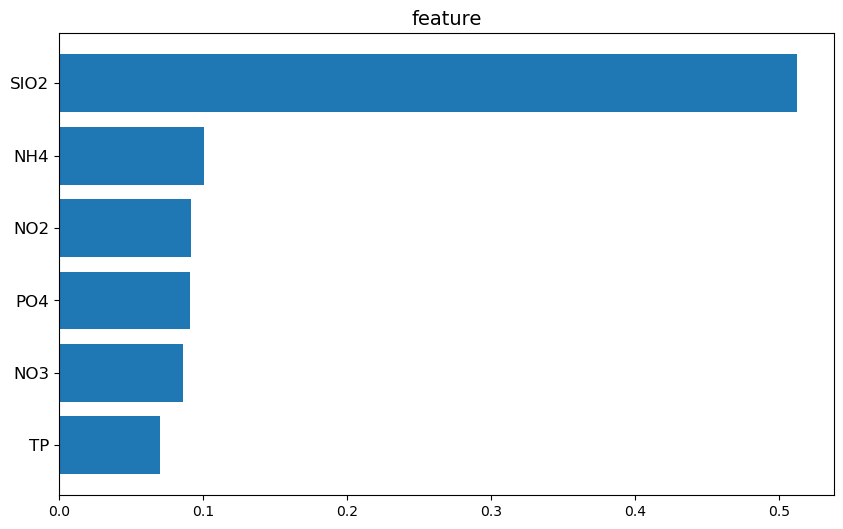

In [17]:
feat_lebels = x_train.columns[0:]
importances  = rfr.feature_importances_
indices = np.argsort(importances)[::-1]
index_list = []
value_list = []
for i,j in zip(range(x_train.shape[1]-1),indices):
    index_list.append(feat_lebels[j])
    value_list.append(importances[j])
    print(i+1, feat_lebels[j], importances[j])

plt.figure(figsize=(10,6))
plt.barh(index_list[::-1],value_list[::-1])
plt.yticks(fontsize = 12)
plt.title('feature',fontsize = 14)
plt.show()

In [18]:
# find best parameters
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators':[50,75,100],
    'min_samples_split':[2,3,5],
    'min_samples_leaf':[1,2,3]
}
grid_seach_rf= GridSearchCV(estimator=RandomForestRegressor(random_state=0),param_grid=param_grid, scoring='neg_mean_squared_error', cv = 5)
grid_seach_rf.fit(x_train, y_train)
best = grid_seach_rf.best_params_
print(best)

{'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 75}


In [21]:
# model
rfr_ = RandomForestRegressor(n_estimators=best['n_estimators'], 
    min_samples_leaf=best['min_samples_leaf'], min_samples_split=best['min_samples_split'],
    random_state=0)
rfr_.fit(x_train, y_train)
y_pred = rfr_.predict(x_test)
print(mean_squared_error(y_test, y_pred))
print(mean_absolute_percentage_error(y_test, y_pred))

0.004165032598614373
12.701298497524476


In [22]:
# score
regressor = RandomForestRegressor(n_estimators=100, min_samples_leaf=5)
regressor.fit(x_train, y_train) 
y_pred = regressor.predict(x_test)
print('sklearn score:{}'.format(r2_score(y_test, y_pred)))  

errors = abs(y_pred - y_test)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:\n', np.round(np.mean(errors), 2), 'degrees.')
mape = 100 * (errors / y_test)
accuracy = 100 - np.mean(mape)
print('Accuracy:\n', round(accuracy, 2), '%.')

sklearn score:0.647779456865148
Mean Absolute Error:
 0.05 degrees.
Accuracy:
 85.45 %.


In [24]:
col = y_pred.shape[0]
y_pred = pd.DataFrame(y_pred[-col:], index=range(col), columns=['quality'])

In [25]:
y_test.shape[0]

38

In [26]:
y_pred

,quality
0,0.443663
1,0.499099
2,0.445518
3,0.241471
4,0.426513
5,0.382162
6,0.418930
7,0.388133
8,0.473393
9,0.284958


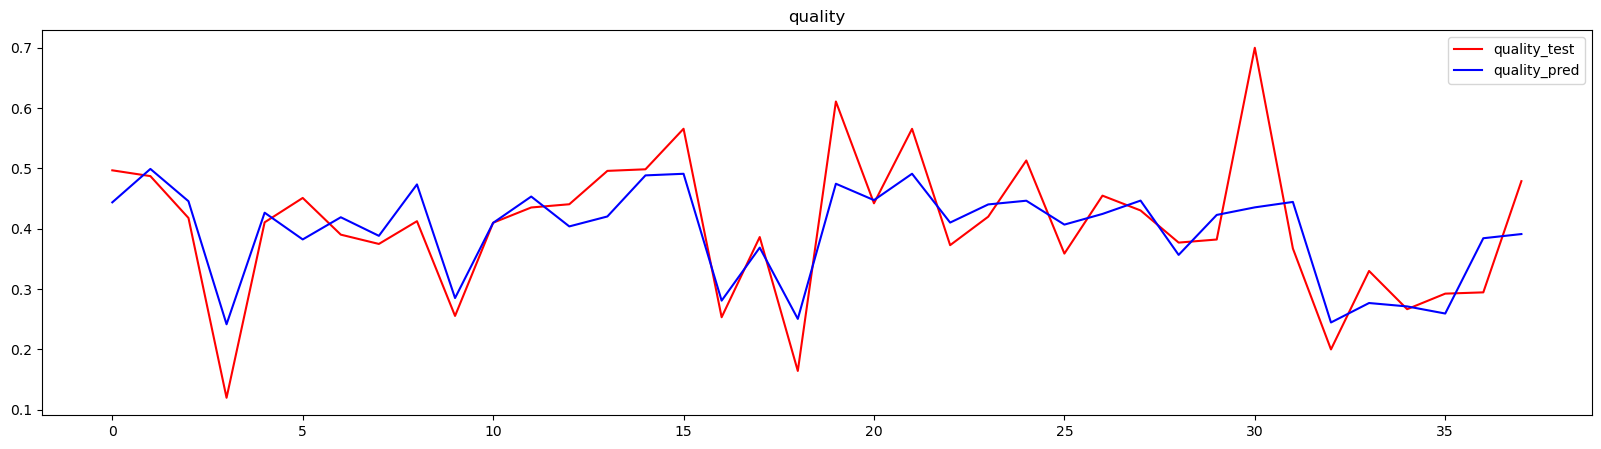

In [28]:
plt.figure(figsize=(20, 5))
plt.plot(y_test[:200], color='red', label='quality_test')
plt.plot(y_pred[:200], color='blue', label='quality_pred')
plt.legend(loc="upper right")
plt.title("quality")
plt.show()
